In [1]:
import numpy as np
from funcs import tikhanov_regularization, gaussian_noise, plot_settings, norm_pow_2
from scipy import optimize
import matplotlib.pyplot as plt

plot_settings()
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
# заводим функции
# 1-v

mu = 8*1e5
f_0 = 300

x_ = lambda t: np.cos(2*np.pi*f_0*t + mu*t**2)

beta = 3*1e3

k_ = lambda t: np.exp(-beta*t)

size = 1000

a, b = 0, 0.01

t = np.linspace(a, b, size)

k = k_(t)
x_exact = x_(t)

f = np.convolve(k, x_exact)

t_conv = np.linspace(a, (t[1]-t[0])*len(f), len(f))

### Метод с известной $\sigma$

In [3]:
def optimal_alpha(sigma, f_n, alpha_0 = 1e-3) -> float:
    x = lambda alpha: tikhanov_regularization(f_n, k, t, alpha)[:t.size]
    Ax = lambda alpha: np.convolve(k, x(alpha))
    func = lambda alpha: np.abs(np.linalg.norm(f_n - Ax(alpha))**2 - sigma**2)
    res = optimize.minimize(func, alpha_0, method="TNC")
    return res.x[0]

### 1.1 Мы знаем $\sigma$

In [4]:
sigma1 = 1

n = 100

alpha1 = [None]*n

for i in range(n):
    f_noise = f + gaussian_noise(f.shape, sigma=sigma1)
    alpha1[i] = optimal_alpha(sigma1, f_noise)

In [5]:
sigma2 = 1e-3

n = 100

alpha2 = [None]*n

for i in range(n):
    f_noise = f + gaussian_noise(f.shape, sigma=sigma2)
    alpha2[i] = optimal_alpha(sigma2, f_noise)

Text(0.5, 1.0, 'log(alpha) histogram for sigma=1')

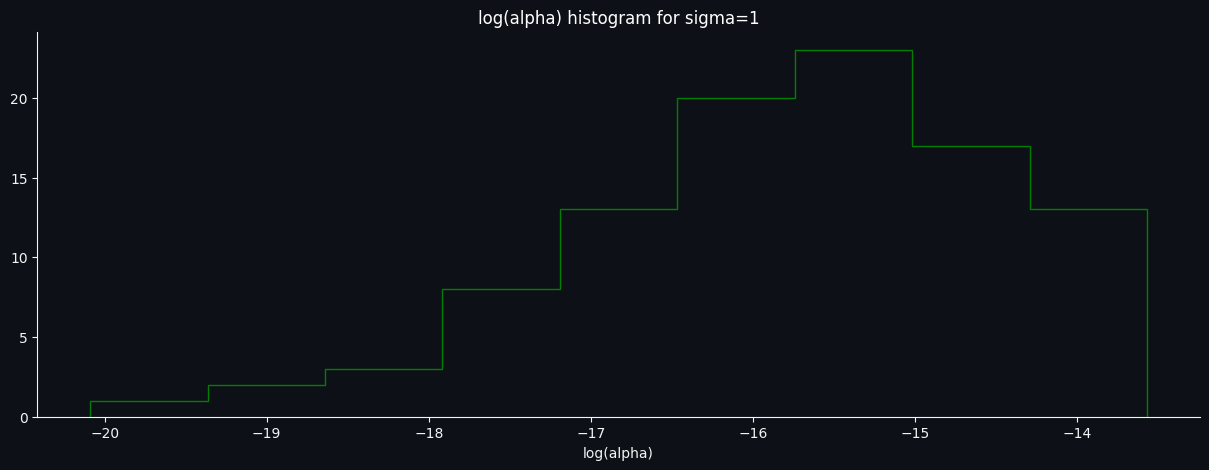

In [6]:
n_bins = int(np.sqrt(n))

alpha_log_1 = np.log(np.abs(alpha1))

plt.hist(alpha_log_1, bins=np.linspace(min(alpha_log_1), max(alpha_log_1), n_bins), histtype="step")
plt.xlabel("log(alpha)")
plt.title(f"log(alpha) histogram for sigma={sigma1}", color='w')

Text(0.5, 1.0, 'log(alpha) histogram for sigma=0.001')

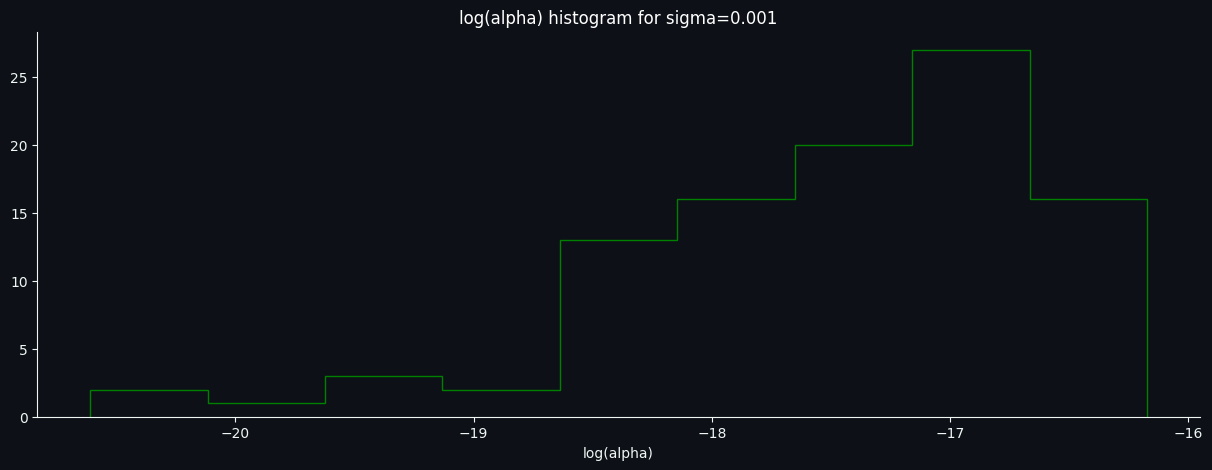

In [7]:
n_bins = int(np.sqrt(n))

alpha_log_2 = np.log(np.abs(alpha2))

plt.hist(alpha_log_2, bins=np.linspace(min(alpha_log_2), max(alpha_log_2), n_bins), histtype="step")
plt.xlabel("log(alpha)")
plt.title(f"log(alpha) histogram for sigma={sigma2}", color='w')

### 1.2 Мы знаем оценку $\sigma$

In [8]:
sigma_real = 1
sigma_upper = 4
sigma_lower = 5e-1

alpha_upper = [None]*n

for i in range(n):
    f_noise = f + gaussian_noise(f.shape, sigma=sigma_upper)
    alpha_upper[i] = optimal_alpha(sigma_upper, f_noise)

In [9]:
alpha_lower = [None]*n

for i in range(n):
    f_noise = f + gaussian_noise(f.shape, sigma=sigma_lower)
    alpha_lower[i] = optimal_alpha(sigma_lower, f_noise)

Text(0.5, 1.0, 'log(alpha) histogram for sigma=0.5')

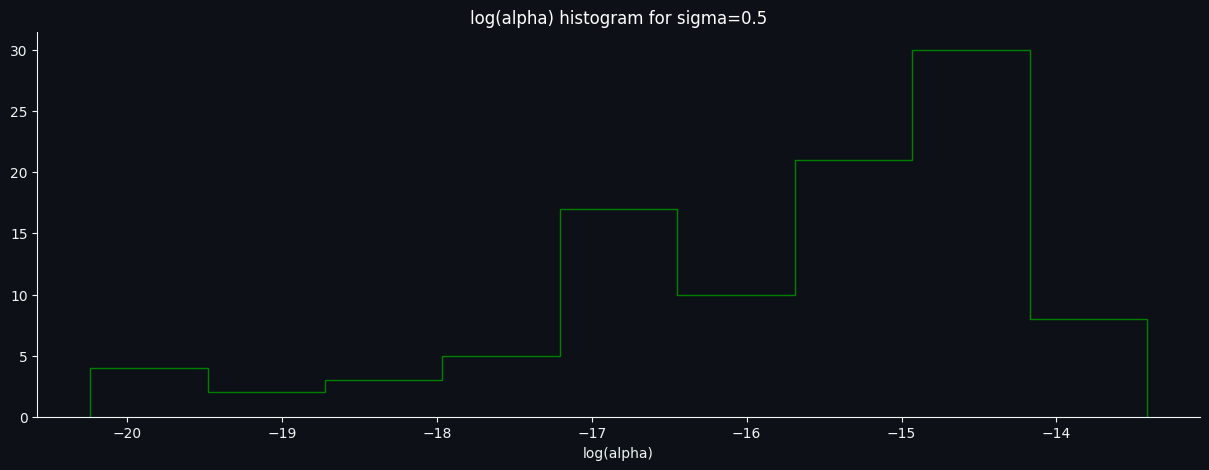

In [10]:
n_bins = int(np.sqrt(n))

alpha_log_lower = np.log(np.abs(alpha_lower))

plt.hist(alpha_log_lower, bins=np.linspace(min(alpha_log_lower), max(alpha_log_lower), n_bins), histtype="step")
plt.xlabel("log(alpha)")
plt.title(f"log(alpha) histogram for sigma={sigma_lower}", color='w')

Text(0.5, 1.0, 'log(alpha) histogram for sigma=4')

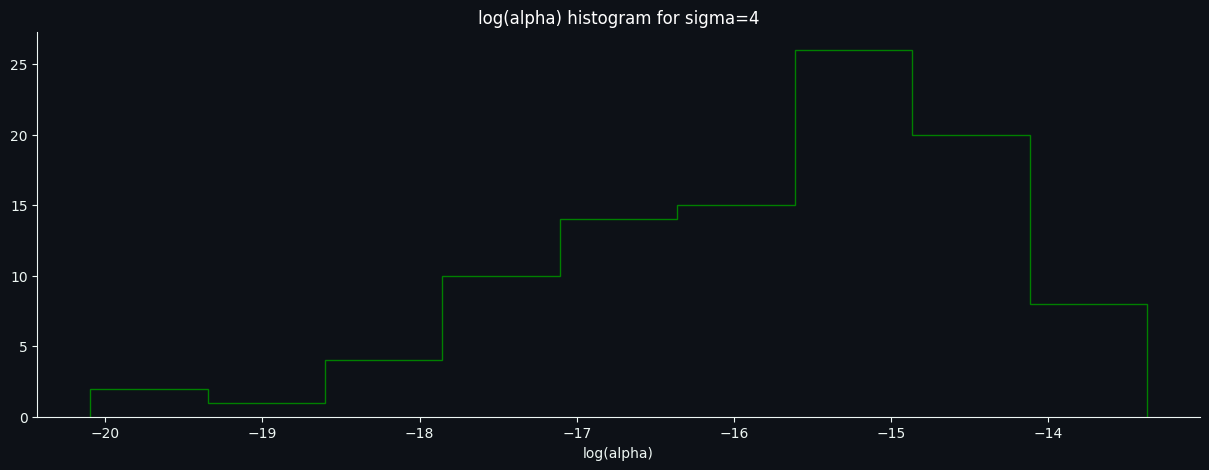

In [11]:
n_bins = int(np.sqrt(n))

alpha_log_upper = np.log(np.abs(alpha_upper))

plt.hist(alpha_log_upper, bins=np.linspace(min(alpha_log_upper), max(alpha_log_upper), n_bins), histtype="step")
plt.xlabel("log(alpha)")
plt.title(f"log(alpha) histogram for sigma={sigma_upper}", color='w')

### 2 График

In [12]:
def norms(alpha):
    x_alpha = tikhanov_regularization(f_noise, k, t, alpha)
    Ax = np.convolve(k, x_alpha)

    norm_y = norm_pow_2(np.float32(Ax[:f_noise.size]), np.float32(f_noise))
    norm_x = norm_pow_2(np.float32(x_alpha), np.zeros_like(x_alpha, dtype=np.float32))

    return norm_x, norm_y

In [13]:

f_noise = f + gaussian_noise(f.shape)
n = 100

alphas = np.linspace(1e-11, 1e-2, 100)

norm_x = [None]*n
norm_y = [None]*n

for i in range(n):
    norm_x[i], norm_y[i] = norms(alphas[i])

Text(0.5, 0, '$||x_{\\alpha}||^2$')

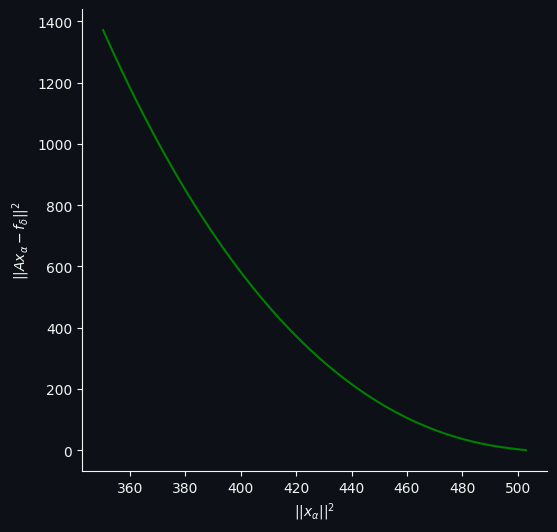

In [14]:
plt.figure(figsize=(6, 6))
plt.plot(norm_x, norm_y)
plt.ylabel(r"$||Ax_{\alpha} - f_{\delta}||^2$")
plt.xlabel(r"$||x_{\alpha}||^2$")

### 3. Метод приращений 

In [15]:
def da_optimal_alpha(f_n, mu=0., alpha_0 = 1e-8, d_alpha=1e-10) -> float:
    x_alpha = lambda alpha: tikhanov_regularization(f_n, k, t, alpha)[:t.size]
    x_d_alpha = lambda alpha: tikhanov_regularization(f_n, k, t, alpha + d_alpha)[:t.size]
    func = lambda alpha: np.linalg.norm(x_alpha(alpha) - x_d_alpha(alpha))
    res = optimize.minimize(func, alpha_0, method="CG")
    return res.x[0]

In [16]:
n = 100

sigma_da = 1e-2

alpha_da = [None]*n

for i in range(n):
    f_noise = f + gaussian_noise(f.shape, sigma=sigma_da)
    alpha_da[i] = da_optimal_alpha(f_noise, d_alpha=1e-5)

Text(0.5, 1.0, 'log(alpha) histogram for sigma=0.01')

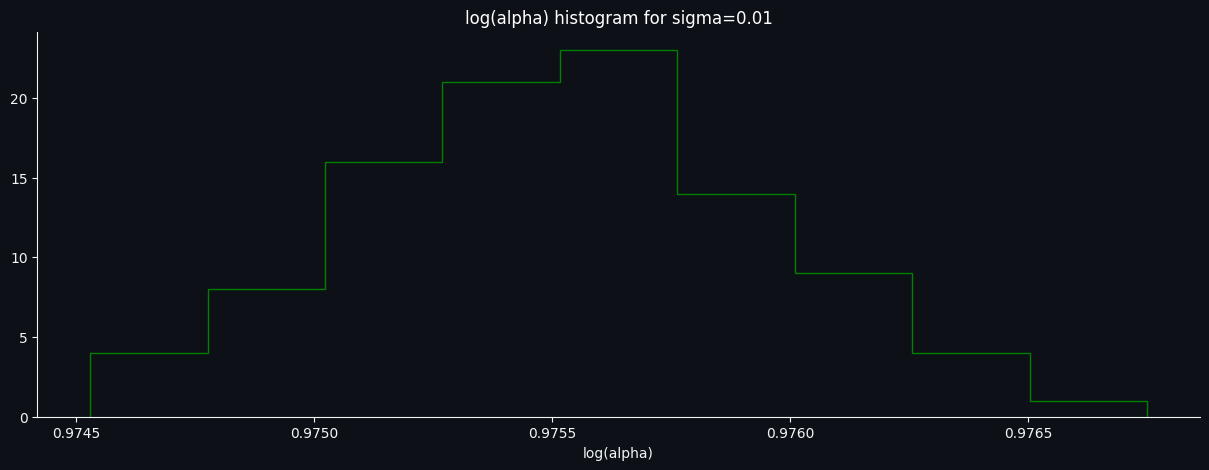

In [17]:
n_bins = int(np.sqrt(n))

alpha_log_da = np.log(np.abs(alpha_da))

plt.hist(alpha_log_da, bins=np.linspace(min(alpha_log_da), max(alpha_log_da), n_bins), histtype="step")
plt.xlabel("log(alpha)")
plt.title(f"log(alpha) histogram for sigma={sigma_da}", color='w')

In [18]:
from scipy.stats import rice
from scipy.fft import fft, ifft 

In [19]:

def neg_log_likelihood(z, sigma):
    # b, loc = params
    #if b <= 0:
    #    return np.inf  # Ensure that b is positive
    log_likelihood = np.sum(rice.logpdf(z, b=1/sigma, scale=sigma))
    return -log_likelihood


In [20]:
def rise_sigma(alpha, f_noise):
    x_alpha = lambda alpha: tikhanov_regularization(f_noise, k, t, alpha)
    x_F = fft(x_alpha(alpha))

    beta = np.zeros_like(x_F)
    beta[:x_F.shape[0]//2] = x_F [:x_F.shape[0]//2]

    gamma = 2*ifft(beta)
    z = np.abs(gamma)

    mle = lambda s: neg_log_likelihood(z, s)
    result = optimize.minimize(mle, 1e-3, method='Powell')
    return result.x[0]

def rice_optimal_alpha(f_noise):
    sigma = lambda alpha: rise_sigma(alpha, f_noise)
    alpha = optimize.minimize(sigma, 1e-3, method="Powell")
    return alpha.x[0]
    

In [21]:
n = 100

sigma_rise = 1e-2

alpha_rise = [None]*n

for i in range(n):
    f_noise = f + gaussian_noise(f.shape, sigma=sigma_da)
    alpha_rise[i] = rice_optimal_alpha(f_noise)

C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_optimize.py:2884: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


Text(0.5, 1.0, 'log(alpha) histogram for sigma=0.01')

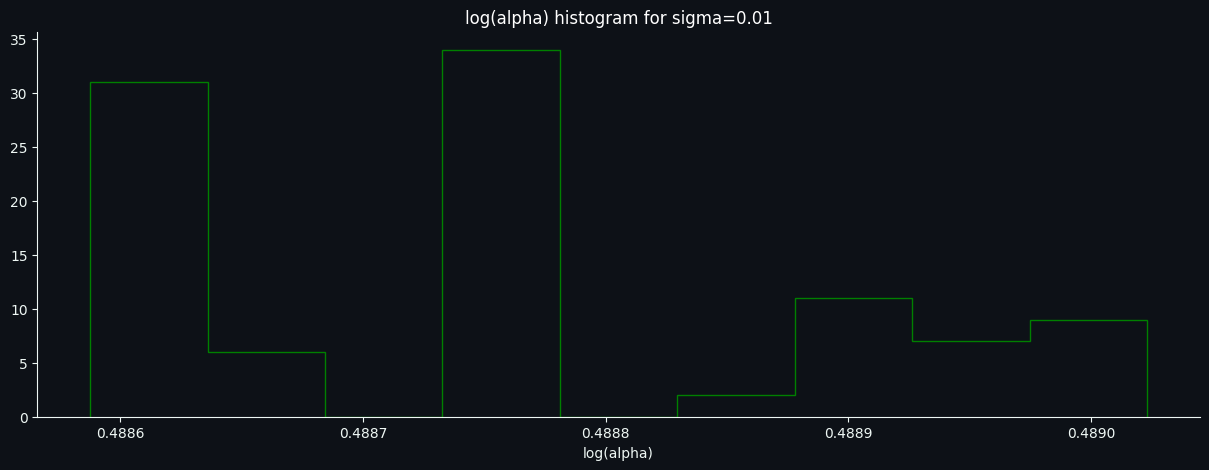

In [22]:
n_bins = int(np.sqrt(n))

alpha_log_rise = np.log(np.abs(alpha_rise))

plt.hist(alpha_log_rise, bins=np.linspace(min(alpha_log_rise), max(alpha_log_rise), n_bins), histtype="step")
plt.xlabel("log(alpha)")
plt.title(f"log(alpha) histogram for sigma={sigma_rise}", color='w')